## Sobhan Asasi
## 400206392

# Install Some Useful Libraries

In [2]:
!pip install transformers
!pip install -q hazm

  Using cached transformers-4.26.0-py3-none-any.whl (6.3 MB)
  Using cached packaging-23.0-py3-none-any.whl (42 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 5.2 MB/s eta 0:00:0000:0100:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 770.0/770.0 kB 8.6 MB/s eta 0:00:00a 0:00:01
  Using cached filelock-3.9.0-py3-none-any.whl (9.7 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.8/661.8 kB 8.6 MB/s eta 0:00:0000:0100:01
  Using cached huggingface_hub-0.12.0-py3-none-any.whl (190 kB)


# Import Packages

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
%matplotlib inline

import gc

import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torchsummary import summary

from transformers import BertTokenizer
from transformers import BertModel

import hazm

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device} device")

cuda device


In [2]:
path = 'Persian_poems_corpus/normalized/'
totla_poets = [['Vahshi Bafqi', path + 'vahshi_norm.txt', 0],
             ['Jami', path + 'jami_norm.txt', 1],
             ['Asadi Tusi', path + 'asadi_norm.txt', 2],
             ['Attar of Nishapur', path + 'attar_norm.txt', 3],
             ['Mohammad Taqi Bahar', path + 'bahar_norm.txt', 4],
             ['Farrokhi Yazdi', path + 'farrokhi_norm.txt', 5],
             ['Ferdowsi', path + 'ferdousi_norm.txt', 6],
             ['Shah Nimatullah Wali', path + 'shahnematollah_norm.txt', 7],
             ['Khwaju Kermani', path + 'khajoo_norm.txt', 8],
             ['Rumi', path + 'moulavi_norm.txt', 9]]
poets_df = pd.DataFrame(totla_poets, columns=['PoetName', 'Nameinfolders', 'PoetID'])
poets_df

,PoetName,Nameinfolders,PoetID
0,Vahshi Bafqi,Persian_poems_corpus/normalized/vahshi_norm.txt,0
1,Jami,Persian_poems_corpus/normalized/jami_norm.txt,1
2,Asadi Tusi,Persian_poems_corpus/normalized/asadi_norm.txt,2
3,Attar of Nishapur,Persian_poems_corpus/normalized/attar_norm.txt,3
4,Mohammad Taqi Bahar,Persian_poems_corpus/normalized/bahar_norm.txt,4
5,Farrokhi Yazdi,Persian_poems_corpus/normalized/farrokhi_norm.txt,5
6,Ferdowsi,Persian_poems_corpus/normalized/ferdousi_norm.txt,6
7,Shah Nimatullah Wali,Persian_poems_corpus/normalized/shahnematollah...,7
8,Khwaju Kermani,Persian_poems_corpus/normalized/khajoo_norm.txt,8
9,Rumi,Persian_poems_corpus/normalized/moulavi_norm.txt,9


In [3]:
data = pd.DataFrame(columns=['beyt', 'poet'])


for i in range(10):
  df = pd.read_csv(poets_df.Nameinfolders[i], header = None)
    
  lst = int(len(df)/2) * [' ']
  df_beyt = pd.DataFrame(lst)

  for k in range(int(len(df)/2)):
    df_beyt.iloc[k] = df.iloc[2*k] + ' [SEP] ' + df.iloc[2*k+1]
  

  df_beyt["poet"] = poets_df.PoetName[i]
  df_beyt.columns = ['beyt', 'poet']
  data = pd.concat([data, df_beyt], ignore_index=True, sort=False)


data = data.sample(frac=1).reset_index(drop=True)

data

,beyt,poet
0,بموختن گر فروتر شوی [SEP] سخن را ز دانندگان بشنوی,Ferdowsi
1,در اینجاگه بدم من چون بزندان [SEP] توام زینجا ...,Attar of Nishapur
2,ندانیم انباز و پیوند و جفت [SEP] نگردد نهان و ...,Ferdowsi
3,دوست باشد طفیل هستی او [SEP] دوست را چون به کا...,Jami
4,سلسله در سلسله می رو بحق [SEP] چون نخواندستی چ...,Attar of Nishapur
...,...,...
280251,هر که خواهد تا سلامت ماند او [SEP] از جمیع خلق...,Attar of Nishapur
280252,هر آنکو شد ز خود پنهان چو منصور [SEP] یکی گردد...,Attar of Nishapur
280253,این خانه نیست مصر و من از قبطیان نیم [SEP] موس...,Mohammad Taqi Bahar
280254,ز شرک خودپرستی گر برستی [SEP] به غیر از حضرت ح...,Shah Nimatullah Wali


In [4]:
train_data, val_data, test_data = np.split(data.sample(frac=1, random_state=42), 
                                     [int(.8*len(data)), int(.9*len(data))])


print(f"Train, Validation, Test split (80:10:10)")
print(f"Train Length: {len(train_data):>17,} \nValidation Length: \
      {len(val_data):,} \nTest Length: {len(test_data):>17,}")

Train, Validation, Test split (80:10:10)
Train Length:           224,204 
Validation Length:       28,026 
Test Length:            28,026


In [5]:
data['beyt_len_by_words'] = data['beyt'].apply(lambda t: len(hazm.word_tokenize(t)))

min_max_len = data["beyt_len_by_words"].min(), data["beyt_len_by_words"].max()
print(f'Min Beyt Len by Words: {min_max_len[0]}')
print(f'Max Beyt Len by Words: {min_max_len[1]}')

Min Beyt Len by Words: 6
Max Beyt Len by Words: 29


In [6]:
tokenizer = BertTokenizer.from_pretrained("HooshvareLab/bert-fa-base-uncased")

In [7]:
example_text = train_data.beyt[0]
bert_input = tokenizer(example_text,padding='max_length', max_length = 32, 
                       truncation=True, return_tensors="pt")


print(f"input_ids: \n{bert_input['input_ids']}\n")
print(f"token_type_ids: \n{bert_input['token_type_ids']}\n")
print(f"attention_mask: \n{bert_input['attention_mask']}\n")

example_text = tokenizer.decode(bert_input.input_ids[0])

print(f"Formatted Sequence: \n{example_text}")

input_ids: 
tensor([[    2, 75467,  8268,  2911, 84690, 16940,     4,  4402,  2803,  1363,
         55265,  3058, 72539,  2003,     4,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]])

token_type_ids: 
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

attention_mask: 
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

Formatted Sequence: 
[CLS] بموختن گر فروتر شوی [SEP] سخن را ز دانندگان بشنوی [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [8]:
labels = dict(zip(poets_df.PoetName, poets_df.PoetID))
labels

{'Vahshi Bafqi': 0,
 'Jami': 1,
 'Asadi Tusi': 2,
 'Attar of Nishapur': 3,
 'Mohammad Taqi Bahar': 4,
 'Farrokhi Yazdi': 5,
 'Ferdowsi': 6,
 'Shah Nimatullah Wali': 7,
 'Khwaju Kermani': 8,
 'Rumi': 9}

In [9]:
class PersianPoemsDataset(torch.utils.data.Dataset):
    """ Create a PyTorch dataset for Persian poems corpus. """

    def __init__(self, df):

        self.labels = [labels[label] for label in df['poet']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 32, truncation=True,
                                return_tensors="pt") for text in df['beyt']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [48]:
ParsBERT = BertModel.from_pretrained('HooshvareLab/bert-fa-base-uncased')
print(ParsBERT)

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(100000, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
         

In [49]:
total_params = sum(p.numel() for p in ParsBERT.parameters() if p.requires_grad)
print(f"Number of Trainable Parameters Before Freezing the Model: {total_params:,}")

for param in ParsBERT.parameters():
  param.requires_grad = False

total_params = sum(p.numel() for p in ParsBERT.parameters() if p.requires_grad)
print(f"Number of Trainable Parameters After Freezing the Model: {total_params:,}")

Number of Trainable Parameters Before Freezing the Model: 162,841,344
Number of Trainable Parameters After Freezing the Model: 0


In [50]:
class BertClassifier(nn.Module):

    def __init__(self):

        super(BertClassifier, self).__init__()

        self.bert = ParsBERT
        self.linear = nn.Linear(768, 10)

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        linear_output = self.linear(pooled_output)

        return linear_output

In [56]:
def train_loop(dataloader, model, loss_fn, optimizer, results, device="cpu"):
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, correct = 0, 0
    model.train()
    for batch, (X, y) in enumerate(dataloader):
    
        mask = X['attention_mask'].to(device)
        input_id = X['input_ids'].squeeze(1).to(device)
        y = y.to(device)
        
        # Compute prediction and loss
        pred = model(input_id, mask)
        #print(pred.shape, y.shape)
        
        loss = loss_fn(pred, y.long())
        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_loss /= num_batches
    correct /= size
    results['train loss'].append(train_loss)
    results['train accuracy'].append(100*correct)
    print(f"Train Metrics: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {train_loss:>8f}")
    
    return train_loss, 100*correct

In [70]:
def valid_loop(dataloader, model, loss_fn, results, device="cpu", mode="valid"):
    
    y_true = []
    y_pred = []
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    model.eval()
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            
            
            mask = X['attention_mask'].to(device)
            input_id = X['input_ids'].squeeze(1).to(device)
            y = y.to(device)
            y_true.extend(y.data.cpu().tolist())
            
            pred = model(input_id, mask)
            y_pred.extend(pred.argmax(1).data.cpu().tolist())
            
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    results['valid loss'].append(test_loss)
    results['valid accuracy'].append(100*correct)
    print(f"Validation Metrics: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")
    
    if mode == "test":
        classes = [i for i in labels]
        print(f" F1: {(100*f1_score(y_true, y_pred, average='micro')):>0.1f}%")
        cf_matrix = confusion_matrix(y_true, y_pred)
        df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) * 100, index = [i for i in classes])
        print('Confusion Matrix:\n')
        print(round(df_cm, 2))
    
    return test_loss, 100*correct

In [58]:
def train_valid(train_loader, valid_loader,  model, loss_fn, optimizer, results, epochs, model_name, device="cpu"):
    
    model.to(device)
    step = 0
    print(f"{model_name}\n-------------------------------")
    for t in range(epochs):
      results['epoch'].append(t+1)
      print(f"Epoch {t+1}\n-------------------------------")
      train_loop(train_loader, model, loss_fn, optimizer, results, device=device)
      valid_loop(valid_loader, model, loss_fn, results, device=device, mode='valid')
      print("---------------------------------------------")
    print("Done!")
    torch.save(model, 'BERT_freeze.pth'.format(model_name))
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    plt.plot(list(range(epochs)), results['train accuracy'])
    plt.plot(list(range(epochs)), results['valid accuracy'])
    plt.title(f'{model_name} Accuracy')
    plt.legend(['train accuracy', 'valid accuracy'])
    plt.subplot(122)
    plt.plot(list(range(epochs)), results['train loss'])
    plt.plot(list(range(epochs)), results['valid loss'])
    plt.title(f'{model_name} Loss')
    plt.legend(['train loss', 'valid loss'])

In [61]:
gc.collect()
torch.cuda.empty_cache()

model = BertClassifier()
EPOCHS = 10
lr = 5e-5
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr= lr)

Bert_Freeze
-------------------------------
Epoch 1
-------------------------------
Train Metrics: 
 Accuracy: 40.6%, Avg loss: 1.790392
Validation Metrics: 
 Accuracy: 45.1%, Avg loss: 1.668253
---------------------------------------------
Epoch 2
-------------------------------
Train Metrics: 
 Accuracy: 44.3%, Avg loss: 1.667362
Validation Metrics: 
 Accuracy: 46.7%, Avg loss: 1.605205
---------------------------------------------
Epoch 3
-------------------------------
Train Metrics: 
 Accuracy: 45.5%, Avg loss: 1.625879
Validation Metrics: 
 Accuracy: 47.4%, Avg loss: 1.575881
---------------------------------------------
Epoch 4
-------------------------------
Train Metrics: 
 Accuracy: 46.2%, Avg loss: 1.602203
Validation Metrics: 
 Accuracy: 48.0%, Avg loss: 1.550834
---------------------------------------------
Epoch 5
-------------------------------
Train Metrics: 
 Accuracy: 46.8%, Avg loss: 1.585458
Validation Metrics: 
 Accuracy: 48.8%, Avg loss: 1.535855
-----------------

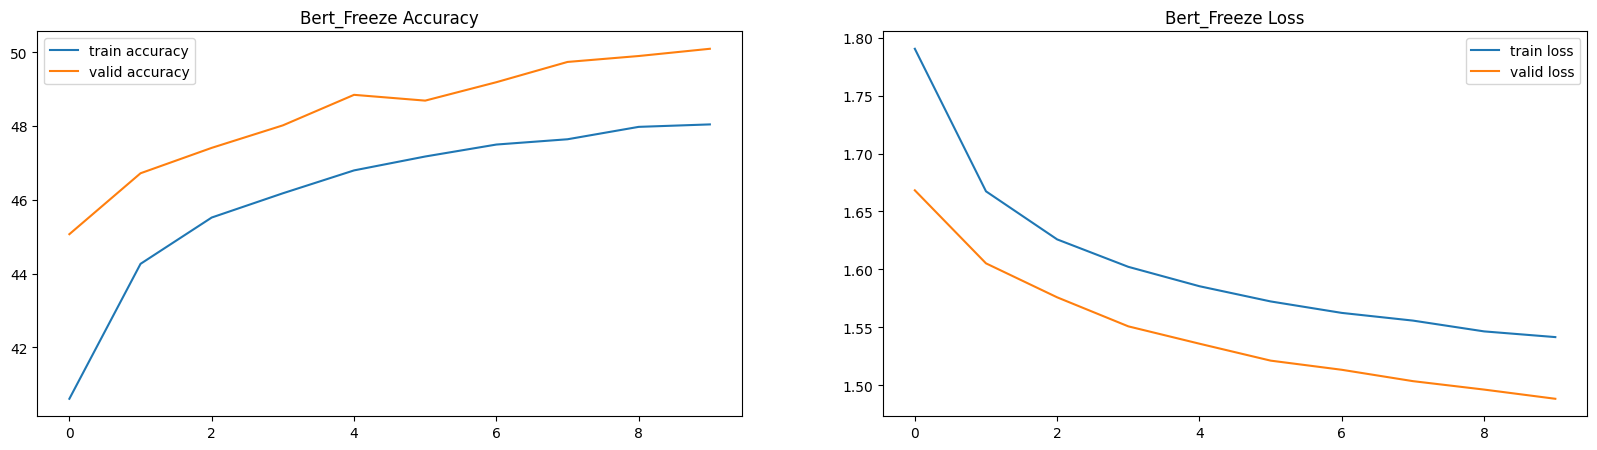

In [62]:
train, val = PersianPoemsDataset(train_data), PersianPoemsDataset(val_data)
test = PersianPoemsDataset(test_data)
train_loader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val, batch_size=32)
test_loader = torch.utils.data.DataLoader(test, batch_size=32)

results = {'epoch':[], 'train loss':[], 'train accuracy':[], 'valid loss':[], 'valid accuracy':[]}
train_valid(train_loader, valid_loader, model, loss_fn, optimizer, results, EPOCHS, model_name="Bert_Freeze", device=device)

In [71]:
valid_loop(test_loader, model, loss_fn, results, device=device, mode="test")

Validation Metrics: 
 Accuracy: 49.0%, Avg loss: 1.494051
 F1: 49.0%
Confusion Matrix:

                         0     1     2      3     4     5      6     7     8  \
Vahshi Bafqi          0.06  0.70  0.01   2.11  0.11  0.03   0.41  0.10  0.08   
Jami                  0.02  3.19  0.01   6.33  0.30  0.04   1.59  0.14  0.04   
Asadi Tusi            0.00  0.27  0.03   0.84  0.07  0.01   1.87  0.01  0.01   
Attar of Nishapur     0.04  1.20  0.00  28.28  0.28  0.04   2.57  0.34  0.12   
Mohammad Taqi Bahar   0.04  1.01  0.01   3.38  0.89  0.06   1.87  0.15  0.02   
Farrokhi Yazdi        0.01  0.26  0.01   2.12  0.17  0.29   1.27  0.03  0.04   
Ferdowsi              0.02  0.59  0.03   3.45  0.19  0.04  13.71  0.04  0.00   
Shah Nimatullah Wali  0.00  0.23  0.00   3.07  0.08  0.01   0.12  1.28  0.05   
Khwaju Kermani        0.03  0.23  0.00   2.20  0.07  0.04   0.16  0.11  0.27   
Rumi                  0.01  0.64  0.00   6.40  0.18  0.05   0.96  0.20  0.03   

                         9  
Va

(1.494050641922646, 48.98665524869764)

## Part 2 : SGD Optimizer

In [72]:
class BertClassifier(nn.Module):

    def __init__(self):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('HooshvareLab/bert-fa-base-uncased')
        self.linear = nn.Linear(768, 10)

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        linear_output = self.linear(pooled_output)

        return linear_output

In [73]:
gc.collect()
torch.cuda.empty_cache()

model_SGD = BertClassifier()

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Bert_Ft_SGD
-------------------------------
Epoch 1
-------------------------------
Train Metrics: 
 Accuracy: 59.1%, Avg loss: 1.212397
Validation Metrics: 
 Accuracy: 63.3%, Avg loss: 1.084683
---------------------------------------------
Epoch 2
-------------------------------
Train Metrics: 
 Accuracy: 64.8%, Avg loss: 1.038219
Validation Metrics: 
 Accuracy: 67.7%, Avg loss: 0.941348
---------------------------------------------
Epoch 3
-------------------------------
Train Metrics: 
 Accuracy: 68.1%, Avg loss: 0.939636
Validation Metrics: 
 Accuracy: 70.4%, Avg loss: 0.865857
---------------------------------------------
Done!


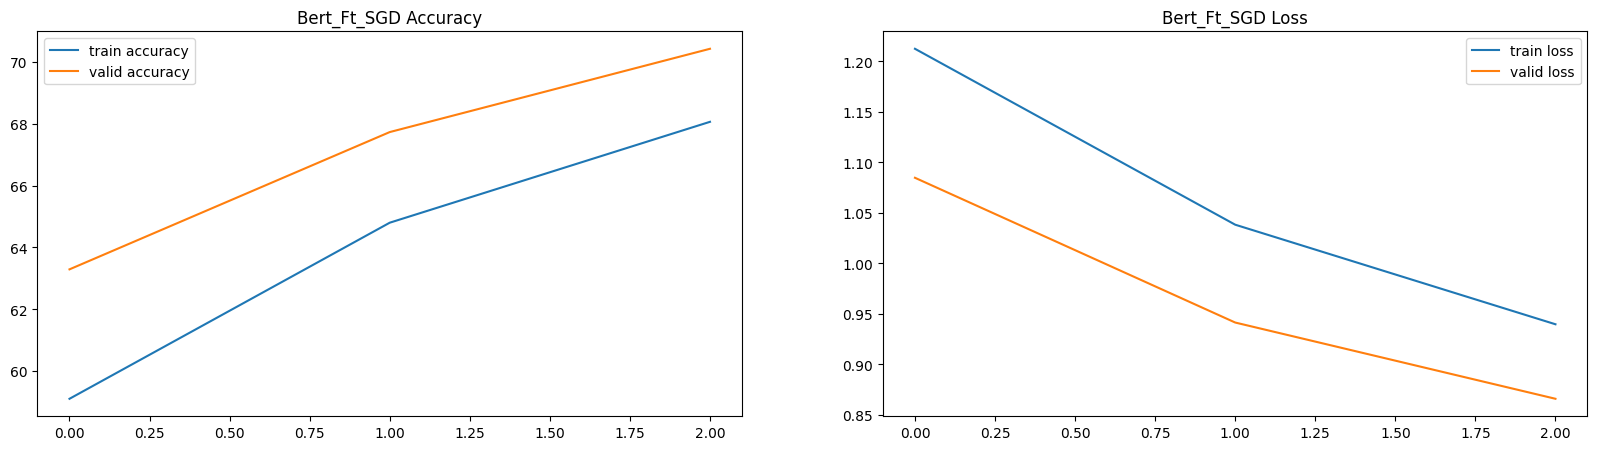

In [75]:
EPOCHS = 3
LR = 5e-5
loss_fn = nn.CrossEntropyLoss()
optimizer = SGD(model_SGD.parameters(), lr= LR, momentum=0.9)
              
results = {'epoch':[], 'train loss':[], 'train accuracy':[], 'valid loss':[], 'valid accuracy':[]}
train_valid(train_loader, valid_loader, model_SGD, loss_fn, optimizer, results, EPOCHS, model_name="Bert_Ft_SGD", device=device)


In [76]:
valid_loop(test_loader, model_SGD, loss_fn, results, device=device, mode="test")

Validation Metrics: 
 Accuracy: 70.5%, Avg loss: 0.865999
 F1: 70.5%
Confusion Matrix:

                         0     1     2      3     4     5      6     7     8  \
Vahshi Bafqi          0.40  1.01  0.04   0.98  0.28  0.17   0.10  0.15  0.28   
Jami                  0.02  8.82  0.10   1.72  0.18  0.02   0.27  0.22  0.01   
Asadi Tusi            0.00  0.22  0.48   0.32  0.06  0.02   1.99  0.00  0.00   
Attar of Nishapur     0.09  1.14  0.05  28.42  0.19  0.12   0.67  0.44  0.22   
Mohammad Taqi Bahar   0.11  1.51  0.06   1.22  2.49  0.62   0.57  0.13  0.21   
Farrokhi Yazdi        0.03  0.31  0.04   0.50  0.35  2.29   0.29  0.04  0.13   
Ferdowsi              0.00  0.18  0.21   0.47  0.05  0.02  17.20  0.00  0.00   
Shah Nimatullah Wali  0.01  0.35  0.00   0.96  0.05  0.02   0.00  3.30  0.09   
Khwaju Kermani        0.06  0.07  0.00   0.67  0.08  0.14   0.01  0.16  1.77   
Rumi                  0.03  0.69  0.01   2.73  0.17  0.11   0.07  0.21  0.09   

                         9  
Va

(0.8659989097959375, 70.53093555983729)

## Part 2 : Adam Optimizer

In [77]:
gc.collect()
torch.cuda.empty_cache()

model_Adam = BertClassifier()

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Bert_Ft_Adam
-------------------------------
Epoch 1
-------------------------------
Train Metrics: 
 Accuracy: 49.8%, Avg loss: 1.511191
Validation Metrics: 
 Accuracy: 58.7%, Avg loss: 1.225310
---------------------------------------------
Epoch 2
-------------------------------
Train Metrics: 
 Accuracy: 61.3%, Avg loss: 1.143641
Validation Metrics: 
 Accuracy: 65.7%, Avg loss: 1.005368
---------------------------------------------
Epoch 3
-------------------------------
Train Metrics: 
 Accuracy: 66.1%, Avg loss: 1.000240
Validation Metrics: 
 Accuracy: 68.4%, Avg loss: 0.928533
---------------------------------------------
Done!


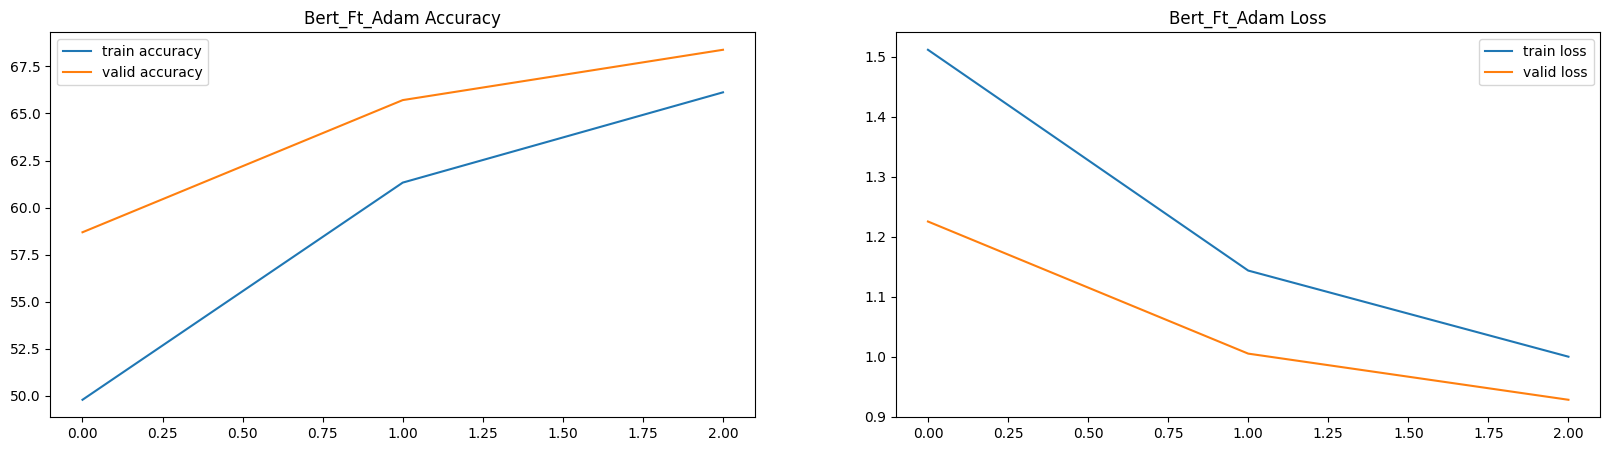

In [78]:
EPOCHS = 3
LR = 5e-5
loss_fn = nn.CrossEntropyLoss()
optimizer = SGD(model_Adam.parameters(), lr= LR, momentum=0.9)
              
results = {'epoch':[], 'train loss':[], 'train accuracy':[], 'valid loss':[], 'valid accuracy':[]}
train_valid(train_loader, valid_loader, model_Adam, loss_fn, optimizer, results, EPOCHS, model_name="Bert_Ft_Adam", device=device)


# Part 3 : Perplexity

The perplexity of the model x is the exponential of its cross entropy


In [83]:
def perplexity(model1, model2, test_data):

    test = PersianPoemsDataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=100)

    

    model1 = model1.to(device)
    model2 = model2.to(device)

    with torch.no_grad():

        for batch, (X, y) in enumerate(test_dataloader):
            
            y = y.to(device) # targets
            
            mask = X['attention_mask'].to(device)
            input_id = X['input_ids'].squeeze(1).to(device)
            
            # model outputs / logits
            output1 = model1(input_id, mask)
            output2 = model2(input_id, mask)
            
            # getting loss using cross entropy
            loss1 = F.cross_entropy(output1, y)
            loss2 = F.cross_entropy(output2, y)
            
            # calculating perplexity
            perplexity1  = torch.exp(loss1)
            perplexity2  = torch.exp(loss2)
            
            return loss1, loss2, perplexity1, perplexity2

In [84]:
loss1, loss2, perplexity1, perplexity2 = perplexity(model, model_Adam, test_data)

loss1 = loss1.cpu().numpy()
loss2 = loss2.cpu().numpy()
perplexity1 = perplexity1.cpu().numpy()
perplexity2 = perplexity2.cpu().numpy()

In [85]:
print(f"Before Fine-tuning:")  
print(f"PP = {perplexity1:>0.4f}")  

Before Fine-tuning:
PP = 3.8622


In [86]:
print(f"After Fine-tuning:")  
print(f"PP = {perplexity2:>0.4f}")

After Fine-tuning:
PP = 2.2663
